In [1]:
import pandas as pd
import numpy as np

from datetime import datetime,timedelta, date
import requests
import io

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns 

from sklearn.neighbors import KernelDensity
from scipy.signal import argrelextrema

import warnings
warnings.filterwarnings("ignore")

### 0. Dataset preparation

In [2]:
#dataset loading
bond_url = 'https://iss.moex.com/iss/apps/infogrid/emission/rates.csv?iss.dp=comma&iss.df=%25d.%25m.%25Y&iss.tf=%25H:%25M:%25S&iss.dtf=%25d.%25m.%25Y%25H:%25M:%25S&iss.only=rates&limit=unlimited&lang=ru'
s=requests.get(bond_url).content
df = pd.read_csv(io.StringIO(s.decode('windows-1251')), sep=';', header=1)

### 1. Data cleaning

In [3]:
# 1. Choosing bonds in RUB

#available currencies
print('Available currencies:\n', df['FACEUNIT'].value_counts())
df_2 = df[df['FACEUNIT'] == 'RUB'].reset_index(drop = True)

Available currencies:
 RUB    2375
USD     337
EUR      46
CHF       9
GBP       2
Name: FACEUNIT, dtype: int64


In [4]:
# 2. Selecting relevant columns

#available columns
print('Available columns:',[col for col in df.columns])

#renaming for convenience
df_2.rename(columns = {'SECID':'ID', 
                       'FACEVALUE':'NOMINAL_VALUE',
                       'INITIALFACEVALUE':'INITIAL_NOMINAL_VALUE',
                       'FACEUNIT':'NOMINAL_CURRENCY',
                       'COUPONDATE':'COUPONDATE_NEXT',
                       'INN':'EMITENT_INN',
                       'MATDATE':'REDEMPTIONDATE'}, inplace = True)

#selecting relevant columns
df_2 = df_2[['EMITENTNAME', 'NAME','INITIAL_NOMINAL_VALUE',
             'COUPONPERCENT','COUPONVALUE','COUPONFREQUENCY',
             'COUPONDATE_NEXT','COUPONDAYSPASSED','COUPONDAYSREMAIN',
             'COUPONLENGTH','PRICE_RUB','ISSUEDATE','REDEMPTIONDATE',
             'DAYSTOREDEMPTION','HIGH_RISK']]

Available columns: ['SECID', 'SHORTNAME', 'NAME', 'TYPENAME', 'ISIN', 'REGNUMBER', 'LISTLEVEL', 'FACEVALUE', 'FACEUNIT', 'ISSUESIZE', 'IS_COLLATERAL', 'IS_EXTERNAL', 'PRIMARY_BOARDID', 'PRIMARY_BOARD_TITLE', 'MATDATE', 'IS_RII', 'EVENINGSESSION', 'MORNINGSESSION', 'DURATION', 'IS_QUALIFIED_INVESTORS', 'HIGH_RISK', 'COUPONFREQUENCY', 'YIELDATWAP', 'COUPONDATE', 'COUPONPERCENT', 'COUPONVALUE', 'COUPONDAYSPASSED', 'COUPONDAYSREMAIN', 'COUPONLENGTH', 'ISSUEDATE', 'INITIALFACEVALUE', 'SECSUBTYPE', 'STARTDATEMOEX', 'DAYSTOREDEMPTION', 'OFFERDATE', 'EMITENTNAME', 'INN', 'LOTSIZE', 'PRICE', 'PRICE_RUB', 'RTL1', 'RTH1', 'RTL2', 'RTH2', 'RTL3', 'RTH3', 'DISCOUNT1', 'LIMIT1', 'DISCOUNT2', 'LIMIT2', 'DISCOUNT3', 'DISCOUNTL0', 'DISCOUNTH0']


In [5]:
# 3. Translation to the correct data format

#data types before correction
print('Data types before correction:\n', df_2.dtypes, '\n')

#a function that corrects data types
def type_changer(x):
    if isinstance(x,str):
        x_new_type = float(x.replace(',','.'))
    else:
        x_new_type = x
    return x_new_type
    
#converting string data to numeric data
for col in ['INITIAL_NOMINAL_VALUE', 'COUPONPERCENT', 'COUPONVALUE',
            'COUPONDAYSPASSED', 'COUPONDAYSREMAIN','COUPONLENGTH', 'PRICE_RUB']:
    df_2[col] = df_2[col].apply(type_changer)
    
#converting string data to datetime
for col in ['COUPONDATE_NEXT','ISSUEDATE', 'REDEMPTIONDATE']:
    df_2[col] = pd.to_datetime(df_2[col])

#data types after correction
print('Data types after correction:\n',df_2.dtypes)

Data types before correction:
 EMITENTNAME               object
NAME                      object
INITIAL_NOMINAL_VALUE     object
COUPONPERCENT             object
COUPONVALUE               object
COUPONFREQUENCY          float64
COUPONDATE_NEXT           object
COUPONDAYSPASSED         float64
COUPONDAYSREMAIN         float64
COUPONLENGTH             float64
PRICE_RUB                 object
ISSUEDATE                 object
REDEMPTIONDATE            object
DAYSTOREDEMPTION         float64
HIGH_RISK                  int64
dtype: object 

Data types after correction:
 EMITENTNAME                      object
NAME                             object
INITIAL_NOMINAL_VALUE           float64
COUPONPERCENT                   float64
COUPONVALUE                     float64
COUPONFREQUENCY                 float64
COUPONDATE_NEXT          datetime64[ns]
COUPONDAYSPASSED                float64
COUPONDAYSREMAIN                float64
COUPONLENGTH                    float64
PRICE_RUB                   

In [6]:
# 4. Missings processing

#n_samples before missings processing
samples_before = df_2.shape[0]
print('Missings before processing:\n',df_2.isnull().sum(), '\n')

#replacement missings of coupon value in relative 
df_2['COUPONPERCENT'].replace(np.nan,0,inplace = True) # missings may mean a coupon-free bond

#replacement missings of coupon value in absolute 
condition = (df_2['COUPONPERCENT'].notna()) & (df_2['COUPONVALUE'].isna()) & (df_2['COUPONFREQUENCY'].notna())
df_2['COUPONVALUE'].loc[condition] = ((df_2['COUPONPERCENT']*df_2['INITIAL_NOMINAL_VALUE'])/df_2['COUPONFREQUENCY'])/100 # COUPONVALUE - вычисляем по формуле

#deleting missings in other columns
for col in ['COUPONFREQUENCY','COUPONDATE_NEXT','COUPONDAYSPASSED',
            'COUPONDAYSREMAIN','COUPONLENGTH','PRICE_RUB',
            'ISSUEDATE','REDEMPTIONDATE','DAYSTOREDEMPTION']:
    
    df_2 = df_2[df_2[col].isnull() == False].reset_index(drop = True)
    
#n_samples after missing processing
print('Missing after processing:\n',df_2.isnull().sum())

Missings before processing:
 EMITENTNAME              145
NAME                       0
INITIAL_NOMINAL_VALUE      0
COUPONPERCENT             58
COUPONVALUE               59
COUPONFREQUENCY          366
COUPONDATE_NEXT            8
COUPONDAYSPASSED           8
COUPONDAYSREMAIN           8
COUPONLENGTH               8
PRICE_RUB                163
ISSUEDATE                145
REDEMPTIONDATE            29
DAYSTOREDEMPTION          29
HIGH_RISK                  0
dtype: int64 

Missing after processing:
 EMITENTNAME              0
NAME                     0
INITIAL_NOMINAL_VALUE    0
COUPONPERCENT            0
COUPONVALUE              0
COUPONFREQUENCY          0
COUPONDATE_NEXT          0
COUPONDAYSPASSED         0
COUPONDAYSREMAIN         0
COUPONLENGTH             0
PRICE_RUB                0
ISSUEDATE                0
REDEMPTIONDATE           0
DAYSTOREDEMPTION         0
HIGH_RISK                0
dtype: int64


In [7]:
# 5. Adding necessary fields

#bond maturity
df_2['DAYSTOREDEMPTION_SINCE_START'] = df_2['REDEMPTIONDATE'] - df_2['ISSUEDATE'] 
df_2['DAYSTOREDEMPTION_SINCE_START'] = df_2['DAYSTOREDEMPTION_SINCE_START'].apply(lambda x: x.days)

#today date
df_2['TODAY'] = date.today() 
df_2['TODAY'] = pd.to_datetime(df_2['TODAY'])

#date of coupon payment
df_2['COUPONDATE_LAST'] = df_2.apply(lambda x: x['TODAY'] - timedelta(days = x['COUPONDAYSPASSED']), axis = 1) 

In [8]:
# 6. Removing errors in calculating coupon payment date

#deleting rows where date of next coupon payment is incorrectly calculated
df_3 = df_2.copy()
df_3['is_mistake_in_coupon_date'] = df_3.apply(lambda x: 0 if x['COUPONDATE_NEXT'] - timedelta(days = x['COUPONDAYSREMAIN']) == x['TODAY'] else 1, axis = 1)
df_3 = df_3[df_3['is_mistake_in_coupon_date'] == 0].reset_index(drop = True)

#deleted rows
samples_after = df_3.shape[0]
print('Deleted samples:', samples_before - samples_after, '\n')

Deleted samples: 1137 



In [9]:
# 7. Exclude bonds with a difference in price and face value >= 20%

df_3 = df_3[df_3['PRICE_RUB']>= (df_3['INITIAL_NOMINAL_VALUE']*0.8)].reset_index(drop = True)

In [10]:
# 8. Forming the final processed dataset with convenient arrangement of columns

df_3 = df_3[['EMITENTNAME','NAME','INITIAL_NOMINAL_VALUE','COUPONPERCENT','COUPONVALUE',
             'COUPONFREQUENCY','COUPONDATE_LAST','COUPONDAYSPASSED','TODAY','COUPONDAYSREMAIN',
             'COUPONDATE_NEXT','COUPONLENGTH','PRICE_RUB','ISSUEDATE','REDEMPTIONDATE',
             'DAYSTOREDEMPTION_SINCE_START','DAYSTOREDEMPTION','HIGH_RISK']]
df_3.head()             

EMITENTNAME  \
0                      Акционерное общество "ДОМ.РФ"   
1                      Акционерное общество "ДОМ.РФ"   
2  открытое акционерное общество "Российские желе...   
3  Акционерное общество "Западный скоростной диам...   
4  Акционерное общество "Западный скоростной диам...   

                          NAME  INITIAL_NOMINAL_VALUE  COUPONPERCENT  \
0    ДОМ.РФ (АО) обл. сер. А14                 1000.0          10.00   
1    ДОМ.РФ (АО) обл. сер. А15                 1000.0           9.25   
2  "Российские ЖД" ОАО 23 обл.                 1000.0           7.85   
3  Запад.скор.диаметр АО об.01                 1000.0          10.44   
4  Запад.скор.диаметр АО об.02                 1000.0          10.44   

   COUPONVALUE  COUPONFREQUENCY COUPONDATE_LAST  COUPONDAYSPASSED      TODAY  \
0        49.59              2.0      2021-11-15             101.0 2022-02-24   
1        45.87              2.0      2021-09-15             162.0 2022-02-24   
2        39.14              2.0      2022-01-20              35.0 2022-02-24   
3        52.06              2.0      2021-11-23              93.0 2022-02-24   
4        52.06              2.0      2021-11-23              93.0 2022-02-24   

   COUPONDAYSREMAIN COUPONDATE_NEXT  COUPONLENGTH  PRICE_RUB  ISSUEDATE  \
0              80.0      2022-05-15         181.0    1046.87 2009-08-27   
1              19.0      2022-03-15         181.0    1131.95 2009-08-27   
2             147.0      2022-07-21         182.0     943.33 2010-04-02   
3              89.0      2022-05-24         182.0    1370.10 2011-07-06   
4              89.0      2022-05-24         182.0    1026.10 2011-07-06   

  REDEMPTIONDATE  DAYSTOREDEMPTION_SINCE_START  DAYSTOREDEMPTION  HIGH_RISK  
0     2023-05-15                          5009             445.0          0  
1     2028-09-15                          6959            2395.0          0  
2     2025-01-16                          5403            1057.0          0  
3     2031-05-13                          7251            3365.0          0  
4     2031-05-13                          7251            3365.0          0

### 2. Calculation of full coupon yield

In [11]:
#accumulated coupon income(ACI)
df_3['ACI_period'] = df_3['COUPONDAYSPASSED']/df_3['COUPONLENGTH']
df_3['ACI'] = df_3['ACI_period'] * (((df_3['COUPONPERCENT']/100)/df_3['COUPONFREQUENCY']) * df_3['INITIAL_NOMINAL_VALUE'])

#future coupon income(FCI)
df_3['FCI_period'] = 365/df_3['COUPONLENGTH'] #the calculation period is 365 days from the current date
df_3['FCI'] = df_3['FCI_period'] * (((df_3['COUPONPERCENT']/100)/df_3['COUPONFREQUENCY']) * df_3['INITIAL_NOMINAL_VALUE']) * 0.87

#tax
df_3['TAX'] = 0.87
df_3['TAX'].loc[df_3['INITIAL_NOMINAL_VALUE'] <= df_3['PRICE_RUB']] = 1

In [12]:
#input
N = df_3['INITIAL_NOMINAL_VALUE']
P = df_3['PRICE_RUB']
tax = df_3['TAX']
FCI = df_3['FCI']
ACI = df_3['ACI']

#broker and exchange commissions
broker_com = 0.06/100
exchange_com = 0.0125/100

#calculation
df_3['PROFIT'] = ((N-P)*tax - ACI + 0.87*FCI)/(1+broker_com+exchange_com)
df_3['COSTS'] = P+ACI
df_3['YIELD_FULL'] = (df_3['PROFIT']/df_3['COSTS']) * 100

##### Emissions analysis

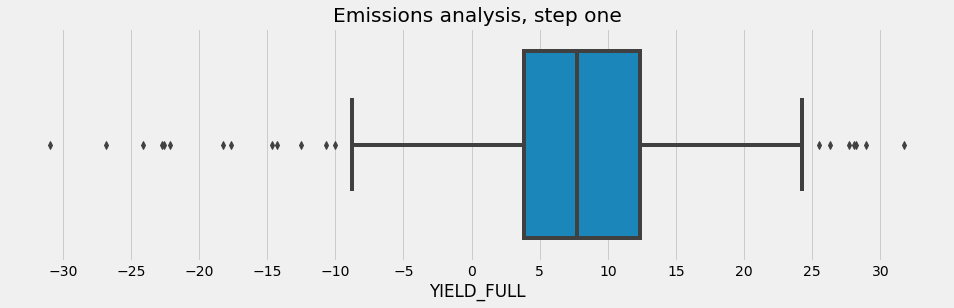

In [13]:
#boxplot of full coupon yield
plt.style.use('fivethirtyeight')
plt.figure(figsize = (15,4))
sns.boxplot(df_3['YIELD_FULL'])
plt.title('Emissions analysis, step one')
plt.xticks(np.linspace(-30,30,13))
plt.show()

In [14]:
# Removing emissions with a yield greater lower 1% quantile and higher 99% quantile (emissions) 
q_1 = np.quantile(df_3['YIELD_FULL'], 0.01)
q_99 = np.quantile(df_3['YIELD_FULL'], 0.99)
df_4 = df_3[(df_3['YIELD_FULL'] >= q_1) & (df_3['YIELD_FULL'] <= q_99)].reset_index(drop = True)

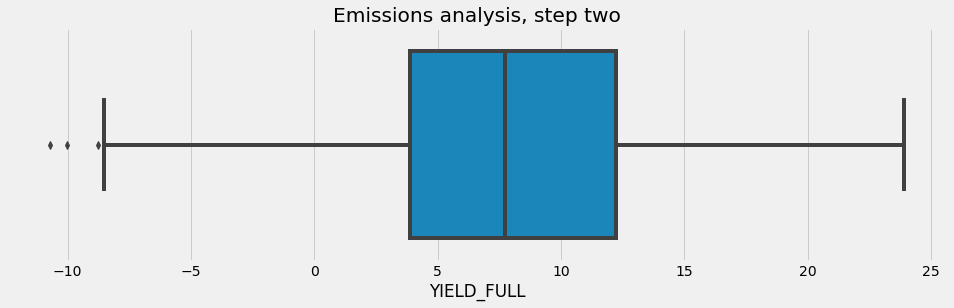

In [15]:
# boxplot of full coupon yield after removing emissions
plt.figure(figsize = (15,4))
sns.boxplot(df_4['YIELD_FULL'])
plt.title("Emissions analysis, step two")
plt.show()

Coclusion: Only three emissions left, other bons are within 1- 99% interval

### 3. Ruble bond market

In [16]:
# issuers with the most bonds
df_4_emitents = df_4.groupby('EMITENTNAME').agg({'NAME':'count'}).reset_index().sort_values('NAME', ascending = False)

# average nominal value, coupon, purchase price, maturity and full yield to maturity by market
df_4.describe().loc['mean'][['INITIAL_NOMINAL_VALUE',
                             'COUPONPERCENT',
                             'PRICE_RUB',
                             'DAYSTOREDEMPTION_SINCE_START',
                             'YIELD_FULL']]

INITIAL_NOMINAL_VALUE           61686.350436
COUPONPERCENT                       7.223393
PRICE_RUB                       58943.164298
DAYSTOREDEMPTION_SINCE_START     2604.815102
YIELD_FULL                          8.268599
Name: mean, dtype: float64

#### 3.1 Distributions

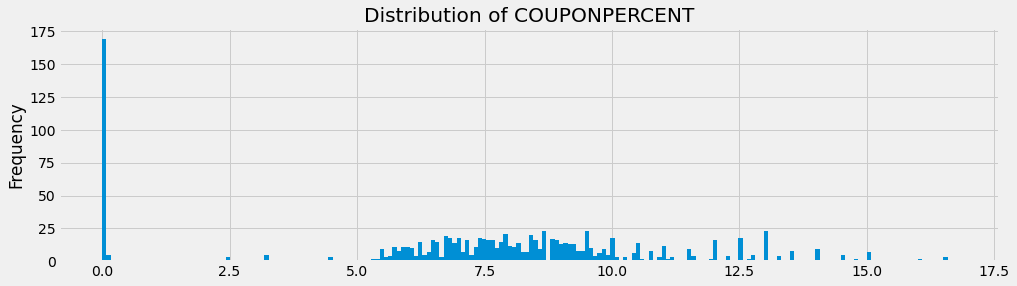

In [17]:
#distribution of COUPONPERCENT
plt.style.use('fivethirtyeight')
df_4['COUPONPERCENT'].plot(kind = 'hist',
                           figsize = (15,4),
                           bins = 200,
                           title = 'Distribution of COUPONPERCENT',
                           xlabel = 'COUPONPERCENT')
plt.show()

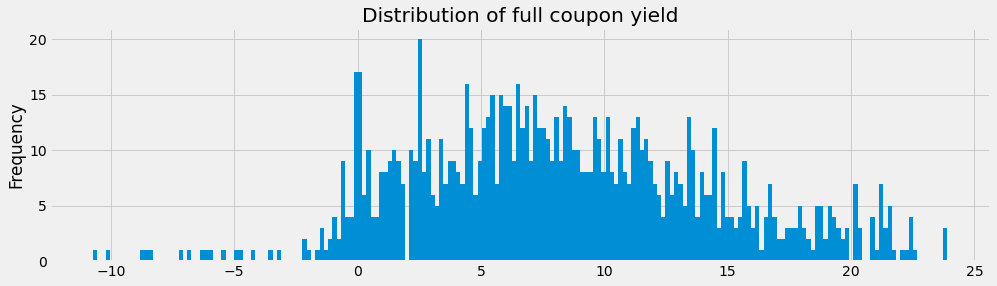

In [18]:
#distribution of full coupon yield (hist)
df_4['YIELD_FULL'].plot(kind = 'hist',
                   figsize = (15,4),
                   bins = 200,
                   title = 'Distribution of full coupon yield',
                   xlabel = 'YIELD_FULL')
plt.show()

### 3. Full coupon yield clustering

In [19]:
#input
X = df_4['YIELD_FULL'].values.reshape(-1, 1)

#### 3.1 distribution of full coupon yield (density)

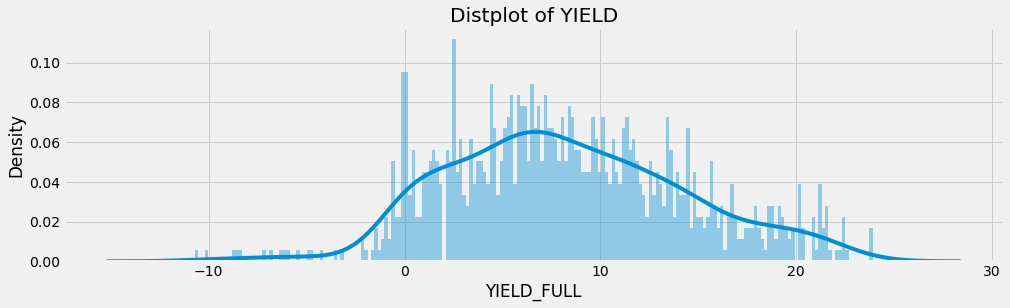

In [20]:
#plot params
plt.figure(figsize = (15,4))
true_dens = sns.distplot(df_4['YIELD_FULL'],bins = 200)
plt.title(f'Distplot of YIELD')
plt.show()

Coclusion: Distribution is close to normal

#### 3.2 Available kernel estimators(K)

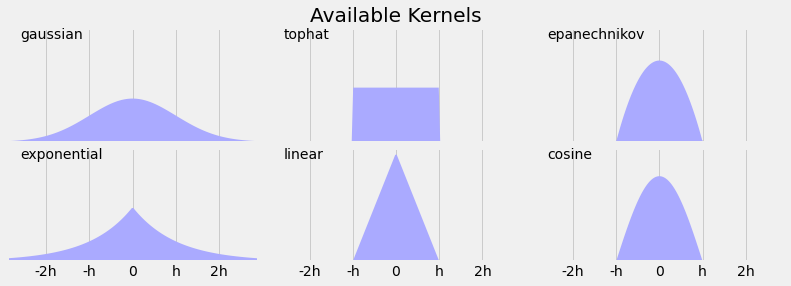

In [21]:
#input
X_plot = np.linspace(np.min(X), np.max(X), len(X)).reshape(-1,1)
X_src = np.zeros((1, 1))
kernels = ["gaussian", "tophat", "epanechnikov", "exponential", "linear", "cosine"]

#plot params
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)
fig.subplots_adjust(left=0.05, right=0.95, hspace=0.05, wspace=0.05)

def format_func(x, loc):
    if x == 0:
        return "0"
    elif x == 1:
        return "h"
    elif x == -1:
        return "-h"
    else:
        return "%ih" % x

#plotting available kernels
for i, kernel in enumerate(kernels):
    
    axi = ax.ravel()[i]
    kde = KernelDensity(kernel=kernel).fit(X_src)
    log_dens = kde.score_samples(X_plot)
    
    axi.fill(X_plot, np.exp(log_dens), "-k", fc="#AAAAFF")
    axi.text(-2.6, 0.95, kernel)

    axi.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    axi.xaxis.set_major_locator(plt.MultipleLocator(1))
    axi.yaxis.set_major_locator(plt.NullLocator())

    axi.set_ylim(0, 1.05)
    axi.set_xlim(-2.9, 2.9)

fig.set_size_inches([12,4])
ax[0, 1].set_title("Available Kernels")
plt.show()

#### 3.3 Kernel estimators of YIELD_FULL (1/nh * sum(K((x-x_i/h))))

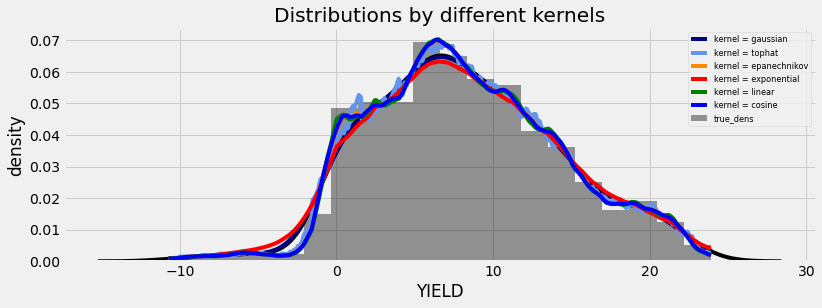

In [22]:
#input
X_plot = np.linspace(np.min(X), np.max(X), len(X)).reshape(-1,1)
h = 1.06 * X.std() * (len(X)**(-1/5)) #bandwidth

colors = ["navy", "cornflowerblue", "darkorange",'red','green','blue']
kernels = ["gaussian", "tophat", "epanechnikov", "exponential", "linear", "cosine"]

#plot true density
fig, ax = plt.subplots()
sns.distplot(X, bins = 20, norm_hist = True, color = 'black', label = 'true_dens' )

#plot kernel density
for color, kernel in zip(colors, kernels):
    
    kde = KernelDensity(kernel=kernel, bandwidth=h).fit(X)
    log_dens = kde.score_samples(X_plot)
    
    ax.plot(X_plot,np.exp(log_dens),color=color,linestyle="-",label=f'kernel = {kernel}')
    
fig.set_size_inches([12,4])
ax.set_xlabel('YIELD')
ax.set_ylabel('density')
ax.set_title('Distributions by different kernels')
ax.legend(loc='best', fontsize = 'xx-small')

plt.show()

Coclusion: Judging by the plot, cosine best estimates the distribution

#### 3.4 Clustering with different kernel estimators. Chossing the best

Grouping kernel gaussian:
error
Grouping kernel tophat:
[[-1.62784068]
 [-0.62147279]
 [ 0.48553189]
 [ 0.61971427]
 [ 0.72035106]
 [ 1.05580703]
 [ 1.65962776]
 [ 2.12926611]
 [ 2.36408529]
 [ 2.73308685]
 [ 2.83372363]
 [ 3.23627079]
 [ 3.73945474]
 [ 3.84009153]
 [ 4.14200189]
 [ 4.24263868]
 [ 4.41036666]
 [ 4.51100345]
 [ 5.21546098]
 [ 5.45028015]
 [ 5.51737134]
 [ 5.78573611]
 [ 5.8863729 ]
 [ 6.12119208]
 [ 6.22182887]
 [ 6.38955685]
 [ 6.59083043]
 [ 6.8256496 ]
 [ 7.19465116]
 [ 7.39592474]
 [ 7.7984719 ]
 [ 7.93265428]
 [ 8.16747346]
 [ 8.26811024]
 [ 8.6706574 ]
 [ 8.93902217]
 [ 9.30802373]
 [ 9.47575171]
 [ 9.54284291]
 [ 9.67702529]
 [ 9.74411648]
 [10.07957245]
 [10.14666364]
 [10.24730043]
 [10.58275639]
 [10.71693878]
 [11.28721392]
 [11.38785071]
 [11.82394346]
 [12.02521704]
 [12.29358181]
 [12.52840098]
 [12.62903777]
 [12.69612896]
 [12.79676575]
 [12.93094814]
 [13.46767768]
 [13.80313364]
 [14.00440722]
 [14.27277199]
 [14.91013832]
 [15.01077511]
 [15.31268548]

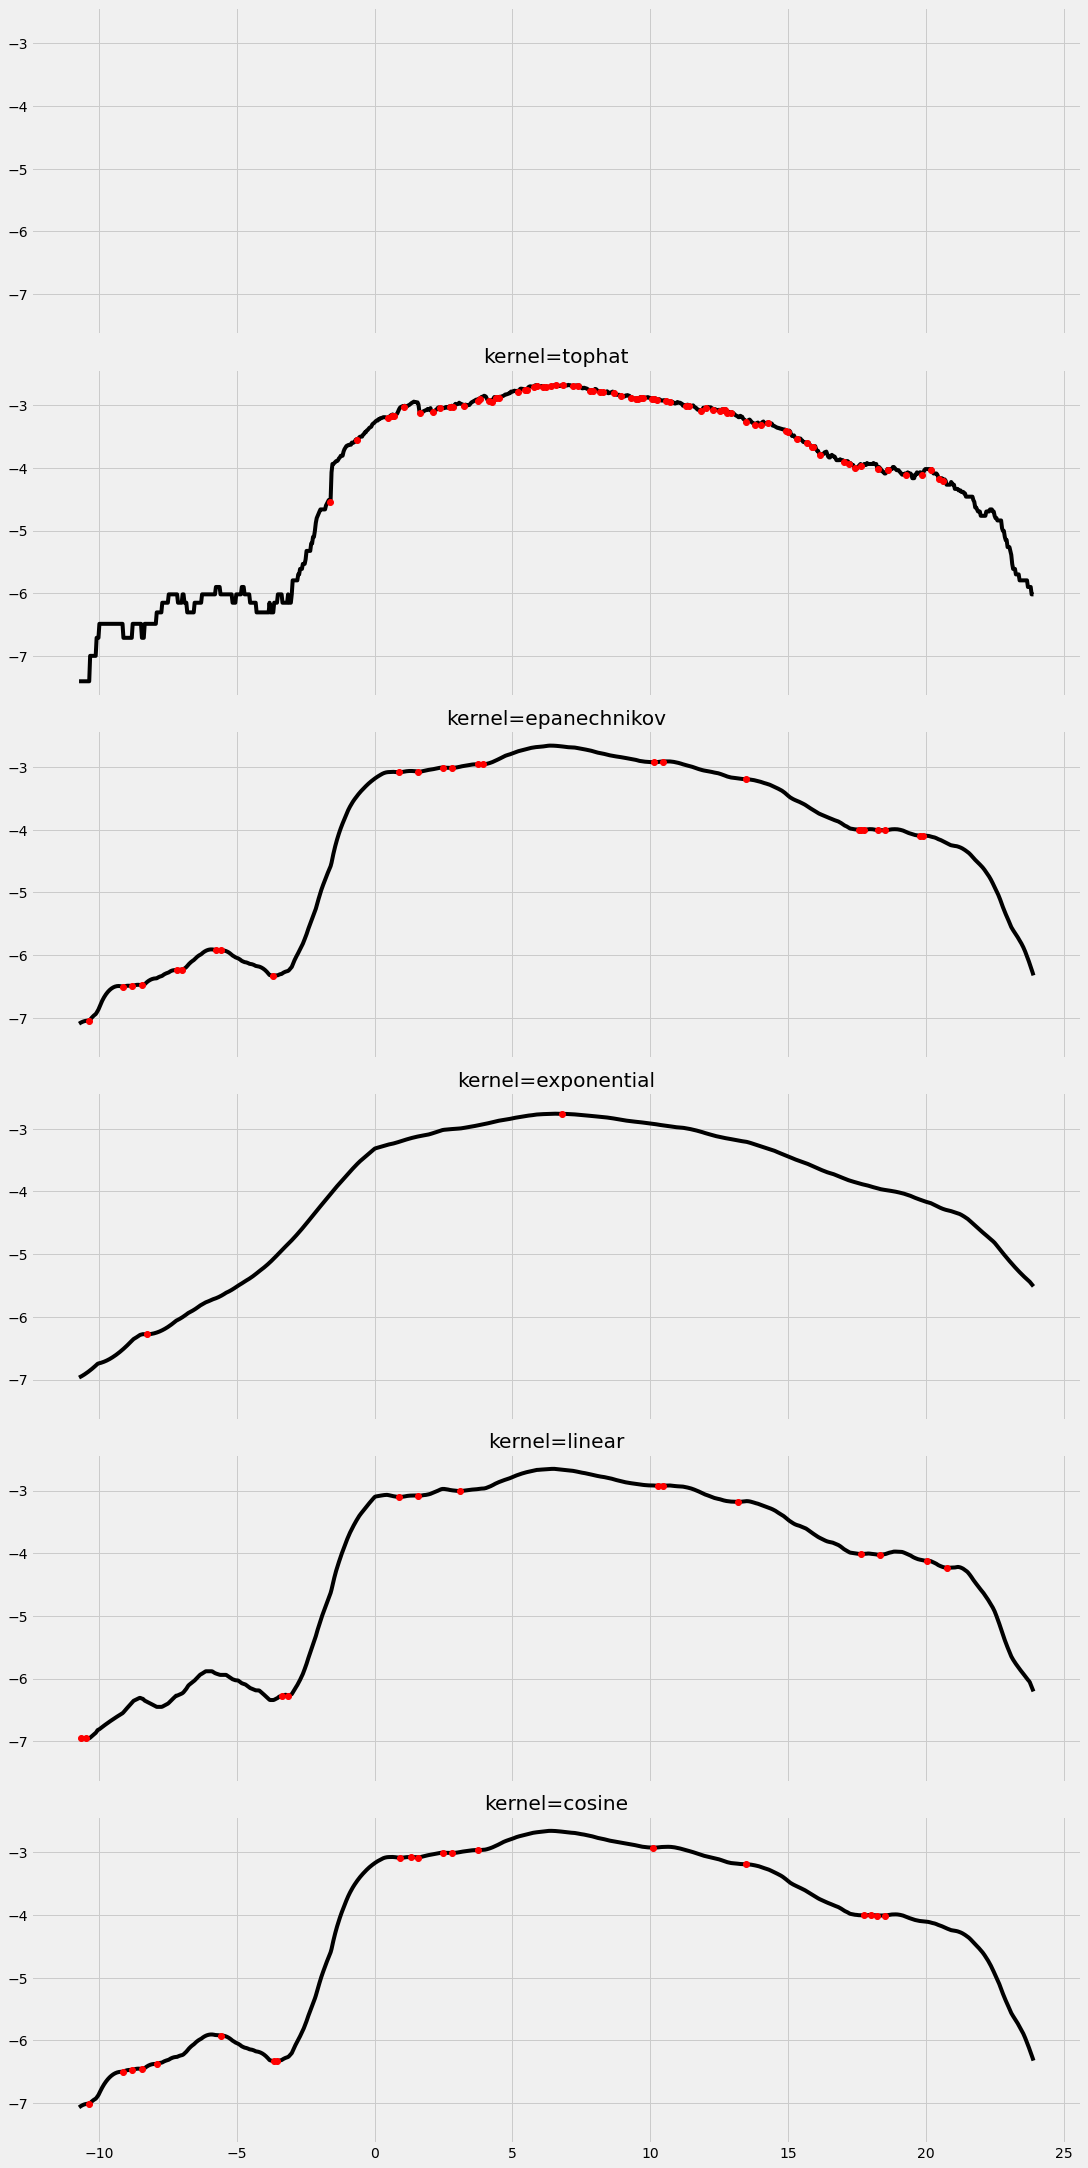

In [23]:
#input
rows = len(kernels)
cols = 1
axs = plt.figure(figsize=(15,30),
                 constrained_layout=True).subplots(rows,cols,sharex=True,sharey=True)

#plot clustering with each kernel estimator
for ax, kernel in zip(axs,kernels):
    
    kde = KernelDensity(kernel=kernel, bandwidth=h).fit(X)
    log_dens = kde.score_samples(X_plot)
    min_, max_ = argrelextrema(log_dens, np.less)[0], argrelextrema(log_dens, np.greater)[0]
    
    print(f'Grouping kernel {kernel}:')
    
    if len(min_) > 1:
        print(X_plot[min_])
        ax.set_title('kernel=%s' % str(kernel))
        ax.plot(X_plot, log_dens, 'black', X_plot[min_], log_dens[min_], 'ro')
        
    else:
        print('error')

#### 3.5 Clustering with the best kernel estimator

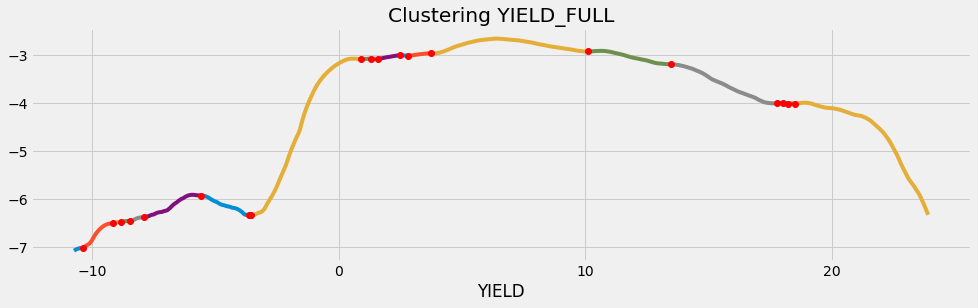

Clustering boundaries:
 [-10.35, -9.14, -8.81, -8.44, -7.9, -5.59, -3.64, -3.54, 0.92, 1.32, 1.59, 2.5, 2.8, 3.74, 10.11, 13.47, 17.76, 18.0, 18.23, 18.5]


In [24]:
#Calculation of boundaries of clustering intervals
kde = KernelDensity(kernel='cosine', bandwidth=h).fit(X)
log_dens = kde.score_samples(X_plot)
min_, max_ = argrelextrema(log_dens, np.less)[0], argrelextrema(log_dens, np.greater)[0]

#Plot a graph visualizing clustering
fig, ax = plt.subplots()

ax.plot(X_plot[:min_[0]+1], log_dens[:min_[0]+1])
for i in range(len(min_)-1):
    ax.plot(X_plot[min_[i]:min_[i+1]+1], log_dens[min_[i]:min_[i+1]+1])

ax.plot(X_plot[min_[len(min_)-1]:], log_dens[min_[len(min_)-1]:])
ax.plot(X_plot[min_], log_dens[min_], 'ro')

fig.set_size_inches([15,4])
ax.set_xlabel('YIELD')
ax.set_title('Clustering YIELD_FULL')
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

plt.show()

#output of boundaries
intervals = [round(i,2) for i in X_plot[min_].reshape(1,-1)[0]]
print('Clustering boundaries:\n',intervals)